In [2]:
import os 
from  typing import List
from pydantic import BaseModel
from langchain_groq.chat_models import ChatGroq
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders  import TextLoader



c:\Users\PARAS\Downloads\agentic-ai-langraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langgraph.graph import StateGraph,START,END


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()


os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
model=ChatGroq(model="openai/gpt-oss-120b")

In [5]:
model.invoke("HI").content

'Hello! How can I assist you today?'

In [6]:
docs=TextLoader("research_notes.txt",encoding="utf-8").load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
chunk=splitter.split_documents(docs)

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings()
vectorstore=FAISS.from_documents(chunk,embedding=embeddings)
retriever=vectorstore.as_retriever()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 622.65it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [9]:
###Define AGENT STATE 
class IterativeRagState(BaseModel):
    question:str

    refined_questions:str=""
    retrieve_docs:List[Document]=[]
    answer:str=""
    verified:bool= False
    attempts:int=0

In [10]:
#Retrieveing the node earlier formed
def retrieved_node(state:IterativeRagState)->IterativeRagState:
    query=state.refined_questions or state.question
    docs=retriever.invoke(query)
    return state.model_copy(update={"retrieved_docs":docs})

In [11]:
#Generate node
def GenerateNode(state:IterativeRagState)->IterativeRagState:
    context="\n\n".join(doc.page_content for doc in state.retrieve_docs)
    prompt=f"""Use the follwing context to answer the follwing question
    
    Context:{context}
    
    Question:{state.question}
    """
    response=model.invoke(prompt.strip()).content.strip()
    return state.model_copy(update={"answer":response,"attempts":state.attempts+1})

In [12]:
def reflect_on_answer(state:IterativeRagState)->IterativeRagState:
    prompt=f"""
    Evaluate wheather the answer below is factually sufficient ans complete
    question:{state.question}
    answer:{state.answer}
    Respond "Yes" if it is  completed otherwise NO with feedback
    """
    feedback=model.invoke(prompt).content.lower()
    verified="yes" in feedback
    return state.model_copy(update={"verified":verified})

In [13]:
def refine_query(state:IterativeRagState)->IterativeRagState:
    prompt=f"""
    The answer appears incomplete Suggested a better version of the query that wpuld help retrieved more relevant Content
    Question:{state.question}
    Answer:{state.answer}

    """
    new_query=model.invoke(prompt).content.strip()
    return state.model_copy(update={"refined_question":new_query})

In [14]:
builder=StateGraph(IterativeRagState)
builder.add_node("retrieve",retrieved_node)
builder.add_node("answer",GenerateNode)
builder.add_node("reflect",reflect_on_answer)
builder.add_node("refine",refine_query)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve","answer")
builder.add_edge("answer","reflect")
builder.add_conditional_edges("reflect", lambda s:END if s.verified or s.attempts >=2 else "refine")

builder.add_edge("refine","retrieve")
builder.add_edge("answer",END)

In [15]:
graph=builder.compile()

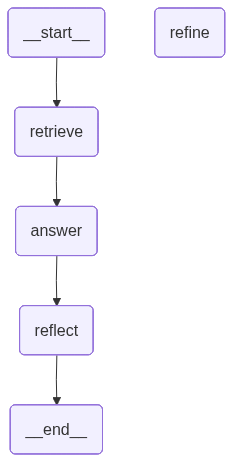

In [16]:
graph

In [22]:
query="agent loops with transformer based systems"
initial_system=IterativeRagState(question=query,)
final=graph.invoke(initial_system)
print("Final Answer",final['answer'])
print("Verfied",final['verified'])

Final Answer ### Agent Loops with Transformer‑Based Systems  

Transformer‑based language models (e.g., GPT‑4, LLaMA, Claude) are exceptionally good at generating natural‑language output, reasoning, and even code.  When you embed such a model inside an **agent loop**, the model becomes a “thinking” component that repeatedly:

1. **Observes** the current state of the environment (text, API responses, sensor data, etc.).
2. **Decides** what to do next (ask a question, call a tool, modify internal state, etc.).
3. **Acts** by invoking a tool, sending a command, or producing a final answer.
4. **Receives feedback** (the tool’s result, an error, or a new observation) and loops back to step 1.

This pattern is often called a **“reason‑act‑observe”** or **“plan‑execute‑observe”** loop.  It lets a single LLM behave like a flexible, multi‑step problem‑solver rather than a one‑shot text generator.

Below is a concise guide covering the core concepts, common architectures, practical implementatio